In [1]:
import control
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
control.aom()
control.aod_h(frequency=100e6)
control.aod_v(frequency=100e6)

scope = control.MSOX6004A('172.22.22.30')
scope.holla()

'AGILENT TECHNOLOGIES,MSO-X 4054A,MY57310545,07.20.2017102615\n'

In [3]:
# max playback sample interval
dT = (2**16 - 1) * 4e-9

# frequency sweep duration
T = 1024 * dT

def downscale(x, N=1024):
    i = np.linspace(0, 1, len(x))
    j = np.linspace(0, 1, N)
    
    return np.interp(j, i, x)

T, dT

(0.26843136, 0.00026214)

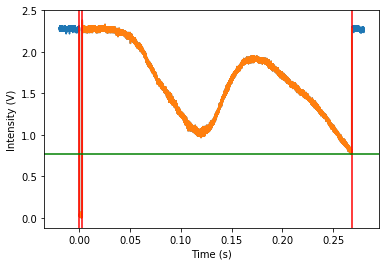

In [6]:
control.aod_h(frequency=100e6)
control.aod_v(frequency=[80e6, 120e6], duration=T, nodwells=[False, True])

df = scope.capture()

t_start = df[df.time > 1e-3].time[df.voltage.diff().idxmax()]
t_stop = T

dfc = df[(df.time > 0) & (df.time < T)]

t = downscale(dfc.time)
U = downscale(dfc.voltage)
U_target = dfc[dfc.time > t_start].voltage.min()

plt.plot(df.time, df.voltage)
plt.plot(dfc.time, dfc.voltage)
plt.axvline(0, c='red')
plt.axvline(t_start, c='red')
plt.axvline(t_stop, c='red')
plt.axhline(U_target, c='green')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (V)')
plt.show()

In [15]:
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from skopt.space import Real

optimizers = [Optimizer([(.3, 1.0)], 'ET', acq_optimizer='sampling') for i in range(1024)]

In [16]:
for i in range(100):
    A = np.array([opt.ask()[0] for opt in optimizers])

    control.aod_v(frequency=[80e6, 120e6], amplitude=A, duration=T, nodwells=[False, True], interval=dT)
    
    df = scope.capture()
    df = df[(df.time > 0) & (df.time < T)]
    
    U = downscale(df.voltage)
    
    for i in range(1024):
        (optimizers[i]).tell([A[i]], (U[i]-U_target)**2)
        
    if i % 10 == 0:
        print(f'error: {np.mean((U-U_target)**2)}')

KeyboardInterrupt: 

In [42]:
df = pd.read_hdf('intensity-data/anticipated-amplitude.h5', 'vsweep')
df = df[(df.time > 0) & (df.time < T)]

t = downscale(df.time.values)
f = 80e6 + 40e6 * t / T
A = np.array([float(c.split('@')[-1][:-1]) for c in df.columns if c.startswith('voltage')])

U = []

for c in df.columns:
    if not c.startswith('voltage'):
        continue
        
    U.append(downscale(df[c].values))

U = np.array(U)

In [47]:
X = np.abs(U-U_target)

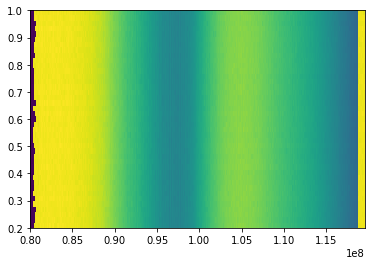

In [52]:
plt.imshow(U, aspect='auto', extent=[f.min(), f.max(), A.min(), A.max()])